In [2892]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
stockfiles=['TCL中环','大全能源','恩捷股份','福斯特','赣锋锂业','华友钴业','晶澳科技','晶盛机电','龙源电力','隆基绿能','宁德时代',
             '三峡能源','天赐材料','天合光能','天齐锂业','通威股份','阳光电源','亿纬锂能','中国广核','中国核电']

In [2893]:
#!pip install lifelines

In [3076]:
#获取股票数
stock_data = pd.read_excel('中国核电cleaned.xlsx')
company='中国核电'

In [3077]:
from datetime import datetime

# 定义字符串
stock_data['Date'] = pd.to_datetime(stock_data['Date'], format='%Y-%m-%d')

In [3078]:
# 计算日收益率
stock_data['daily_return'] = (stock_data['ClosePrice'] - stock_data['OpenPrice']) / stock_data['OpenPrice']
stock_data = stock_data.dropna()
stock_data = stock_data.reset_index()
stock_data = stock_data.drop('index', axis=1)

In [3079]:
# 定义Dα和Dβ的阈值
alpha = 0.01
beta = -0.01

In [3080]:
stock_data=stock_data.drop('Unnamed: 0', axis=1)
stock_data=stock_data.drop('ClosePrice_returns', axis=1)
stock_data

,StockCode,StockName,Date,OpenPrice,HighestPrice,LowestPrice,ClosePrice,Turnover,TradingVolume,daily_return
0,601985.SH,中国核电,2015-06-11,5.37,5.37,5.37,5.37,2.05,381000.0,0.000000
1,601985.SH,中国核电,2015-06-12,5.91,5.91,5.91,5.91,2.33,394600.0,0.000000
2,601985.SH,中国核电,2015-06-15,6.50,6.50,6.50,6.50,3.83,589500.0,0.000000
3,601985.SH,中国核电,2015-06-16,7.15,7.15,7.15,7.15,5.77,807100.0,0.000000
4,601985.SH,中国核电,2015-06-17,7.87,7.87,7.87,7.87,12.06,1532200.0,0.000000
...,...,...,...,...,...,...,...,...,...,...
1909,601985.SH,中国核电,2023-04-17,7.84,7.98,7.74,7.95,741.14,108571100.0,0.014031
1910,601985.SH,中国核电,2023-04-18,7.94,7.94,7.84,7.85,451.62,66350100.0,-0.011335
1911,601985.SH,中国核电,2023-04-19,7.83,8.01,7.81,7.87,649.68,94537600.0,0.005109
1912,601985.SH,中国核电,2023-04-20,7.86,7.93,7.77,7.87,590.81,87093100.0,0.001272


In [3081]:
# 初始化事件状态列和生存时间列
stock_data['is_alpha'] = 0
stock_data['is_beta'] = 0
stock_data['T_alpha'] = 0
stock_data['T_beta'] = 0
stock_data['last_alpha_index'] = 0
stock_data['last_beta_index'] = 0
# 初始化上一次出现Dα和Dβ的index
last_alpha_index = 0
last_beta_index = 0

In [3082]:
# 遍历每一天的数据，更新事件状态和生存时间
# 更新Dα状态和生存时间
# 遍历每一天的数据，更新事件状态和生存时间
# 更新Dα状态和生存时间
for i in range(len(stock_data)):
    if stock_data.loc[i, 'daily_return'] > alpha:
      stock_data.loc[i, 'is_alpha'] = 1
      stock_data.loc[i, 'last_alpha_index'] = last_alpha_index
      last_alpha_index = i
    else:
      stock_data.loc[i, 'is_alpha'] = 0
      stock_data.loc[i, 'last_alpha_index'] = last_alpha_index
for i in range(len(stock_data)):
  if i == 0:
    stock_data.loc[i, 'T_alpha'] = 1
  else:
    if stock_data.loc[i, 'last_alpha_index'] == 0 and stock_data.loc[0, 'is_alpha'] == 0:
      stock_data.loc[i, 'T_alpha'] = i - stock_data.loc[i, 'last_alpha_index'] + 1
    else:
      stock_data.loc[i, 'T_alpha'] = i - stock_data.loc[i, 'last_alpha_index']
# 更新Dβ状态和生存时间
# 更新Dβ状态和生存时间
for i in range(len(stock_data)):
    if stock_data.loc[i, 'daily_return'] < beta:
      stock_data.loc[i, 'is_beta'] = 1
      stock_data.loc[i, 'last_beta_index'] = last_beta_index
      last_beta_index = i
    else:
      stock_data.loc[i, 'is_beta'] = 0
      stock_data.loc[i, 'last_beta_index'] = last_beta_index
for i in range(len(stock_data)):
  if i == 0:
    stock_data.loc[i, 'T_beta'] = 1
  else:
    if stock_data.loc[i, 'last_beta_index'] == 0 and stock_data.loc[0, 'is_beta'] == 0:
      stock_data.loc[i, 'T_beta'] = i - stock_data.loc[i, 'last_beta_index'] + 1
    else:
      stock_data.loc[i, 'T_beta'] = i - stock_data.loc[i, 'last_beta_index']

In [3083]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1914 entries, 0 to 1913
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   StockCode         1914 non-null   object        
 1   StockName         1914 non-null   object        
 2   Date              1914 non-null   datetime64[ns]
 3   OpenPrice         1914 non-null   float64       
 4   HighestPrice      1914 non-null   float64       
 5   LowestPrice       1914 non-null   float64       
 6   ClosePrice        1914 non-null   float64       
 7   Turnover          1914 non-null   float64       
 8   TradingVolume     1914 non-null   float64       
 9   daily_return      1914 non-null   float64       
 10  is_alpha          1914 non-null   int64         
 11  is_beta           1914 non-null   int64         
 12  T_alpha           1914 non-null   int64         
 13  T_beta            1914 non-null   int64         
 14  last_alpha_index  1914 n

In [3084]:
import ta
# Define time range for covariates
T = 30  # number of days

# Calculate the cumulative returns from the latest event to current time
stock_data['cumulative_returns'] = (pd.Series(np.cumprod(1 + stock_data["daily_return"][::-1]), index=stock_data.index[::-1])).values[::-1]

In [3085]:
# Calculate AcROC
stock_data['AcROC'] = stock_data['cumulative_returns']

# Calculate AvROC
stock_data['AvROC'] = stock_data['cumulative_returns'].rolling(window=len(stock_data), min_periods=1).mean()

# Calculate AcT
stock_data['AcT'] = np.cumsum(stock_data['Turnover'][::-1]).fillna(0)[::-1]

# Calculate AvT
stock_data['AvT'] = stock_data['Turnover'].rolling(window=T).mean().fillna(0)

# Calculate K%
rolling_high = stock_data['ClosePrice'].rolling(window=T).max()
rolling_low = stock_data['ClosePrice'].rolling(window=T).min()
stock_data['K%'] = (stock_data['ClosePrice'] - rolling_low) / (rolling_high - rolling_low) * 100

# Calculate D%
stock_data['D%'] = stock_data['K%'].rolling(window=T).mean().fillna(0)

# Calculate J%
stock_data['J%'] = 3 * stock_data['K%'] - 2 * stock_data['D%']


# Calculate RSI
def calc_rsi(x):
    if len(x[x >= 0]) == 0:
        return 0
    if len(x[x < 0]) == 0:
        return 100
    avg_gain = x[x >= 0].mean()
    avg_loss = -x[x < 0].mean()
    rs = avg_gain / avg_loss
    return 100 - 100 / (1 + rs)
stock_data['RSI'] = stock_data['ClosePrice'].pct_change().rolling(window=T).apply(calc_rsi, raw=True).fillna(0)

# Calculate PSY
stock_data['PSY'] = stock_data["daily_return"].apply(lambda x: 1 if x > 0 else 0).rolling(window=len(stock_data), min_periods=1).mean()


# Print the resulting data frame
print(stock_data)

      StockCode StockName       Date  OpenPrice  HighestPrice  LowestPrice  \
0     601985.SH      中国核电 2015-06-11       5.37          5.37         5.37   
1     601985.SH      中国核电 2015-06-12       5.91          5.91         5.91   
2     601985.SH      中国核电 2015-06-15       6.50          6.50         6.50   
3     601985.SH      中国核电 2015-06-16       7.15          7.15         7.15   
4     601985.SH      中国核电 2015-06-17       7.87          7.87         7.87   
...         ...       ...        ...        ...           ...          ...   
1909  601985.SH      中国核电 2023-04-17       7.84          7.98         7.74   
1910  601985.SH      中国核电 2023-04-18       7.94          7.94         7.84   
1911  601985.SH      中国核电 2023-04-19       7.83          8.01         7.81   
1912  601985.SH      中国核电 2023-04-20       7.86          7.93         7.77   
1913  601985.SH      中国核电 2023-04-21       7.87          7.96         7.76   

      ClosePrice  Turnover  TradingVolume  daily_return  ...  \

In [3086]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1914 entries, 0 to 1913
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   StockCode           1914 non-null   object        
 1   StockName           1914 non-null   object        
 2   Date                1914 non-null   datetime64[ns]
 3   OpenPrice           1914 non-null   float64       
 4   HighestPrice        1914 non-null   float64       
 5   LowestPrice         1914 non-null   float64       
 6   ClosePrice          1914 non-null   float64       
 7   Turnover            1914 non-null   float64       
 8   TradingVolume       1914 non-null   float64       
 9   daily_return        1914 non-null   float64       
 10  is_alpha            1914 non-null   int64         
 11  is_beta             1914 non-null   int64         
 12  T_alpha             1914 non-null   int64         
 13  T_beta              1914 non-null   int64       

In [3087]:
#stock_dataa = stock_data.drop(['StockCode','StockName','Date','OpenPrice','HighestPrice','LowestPrice','ClosePrice'], axis = 1)

In [3088]:
stock_dataa = stock_data.drop('daily_return',axis = 1)

In [3089]:
stock_dataa = stock_dataa.drop(['StockCode','StockName','OpenPrice','HighestPrice','LowestPrice','ClosePrice','Turnover','TradingVolume'], axis = 1)

In [3090]:
stock_datab=stock_dataa 

# Increase prediction Alpha

In [3091]:
stock_dataa = stock_dataa.drop(['last_alpha_index','last_beta_index','is_beta','T_beta','cumulative_returns'], axis = 1)

In [3092]:
stock_dataa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1914 entries, 0 to 1913
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1914 non-null   datetime64[ns]
 1   is_alpha  1914 non-null   int64         
 2   T_alpha   1914 non-null   int64         
 3   AcROC     1914 non-null   float64       
 4   AvROC     1914 non-null   float64       
 5   AcT       1914 non-null   float64       
 6   AvT       1914 non-null   float64       
 7   K%        1885 non-null   float64       
 8   D%        1914 non-null   float64       
 9   J%        1885 non-null   float64       
 10  RSI       1914 non-null   float64       
 11  PSY       1914 non-null   float64       
dtypes: datetime64[ns](1), float64(9), int64(2)
memory usage: 179.6 KB


In [3093]:
stock_dataa = stock_dataa.dropna()
stock_dataa = stock_dataa.reset_index()
stock_dataa = stock_dataa.drop('index', axis=1)
# 设置日期列为索引
stock_dataa = stock_dataa.set_index('Date')

In [3094]:
stock_dataa.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1885 entries, 2015-07-23 to 2023-04-21
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   is_alpha  1885 non-null   int64  
 1   T_alpha   1885 non-null   int64  
 2   AcROC     1885 non-null   float64
 3   AvROC     1885 non-null   float64
 4   AcT       1885 non-null   float64
 5   AvT       1885 non-null   float64
 6   K%        1885 non-null   float64
 7   D%        1885 non-null   float64
 8   J%        1885 non-null   float64
 9   RSI       1885 non-null   float64
 10  PSY       1885 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 176.7 KB


In [3095]:
#stock_dataa.tail(50)

In [3096]:
Xa = stock_dataa
ya = stock_dataa[['is_alpha', 'T_alpha']]# replace 'target_variable' with the name of the variable you're trying to predict

In [3097]:
#Xa

In [3098]:
# 将历史数据作为训练集
# 将2023年2月份的数据作为测试集
Xa_train = Xa.loc[:'2022-12-30']
Xa_test  =Xa.loc['2023-01-01':'2023-03-31']

In [3099]:
Xa_train  # t alpha 本质上由 is alpha获得
Xa_train1=Xa_train.drop('is_alpha',axis = 1)
Xa_train1=Xa_train1.drop('T_alpha',axis = 1)

In [3100]:
#Xa_test

In [3101]:
ya_train = ya.loc[:'2022-12-30']
ya_test=ya.loc['2023-01-01':'2023-03-31']

In [3102]:
from lifelines import CoxPHFitter
Xa_test = Xa_test.drop('is_alpha',axis = 1)
Xa_test =Xa_test.drop('T_alpha',axis = 1)

In [3103]:
#ya_train

In [3104]:
#ya_test

In [3105]:
# 创建Cox回归模型
cph = CoxPHFitter(penalizer=0.1)

# 使用训练集对模型进行拟合
cph.fit(Xa_train, duration_col='T_alpha', event_col='is_alpha', show_progress=True)

Iteration 1: norm_delta = 0.65883, step_size = 0.9500, log_lik = -2456.72306, newton_decrement = 148.55569, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.09722, step_size = 0.9500, log_lik = -2336.30843, newton_decrement = 12.55158, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.03404, step_size = 0.9500, log_lik = -2322.37674, newton_decrement = 1.01977, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00364, step_size = 1.0000, log_lik = -2321.29542, newton_decrement = 0.00985, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.00004, step_size = 1.0000, log_lik = -2321.28550, newton_decrement = 0.00000, seconds_since_start = 0.0
Iteration 6: norm_delta = 0.00000, step_size = 1.0000, log_lik = -2321.28550, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 6 iterations.


<lifelines.CoxPHFitter: fitted with 1812 total observations, 1449 right-censored observations>

In [3106]:
# Print coefficients and hazard ratios
print(cph.summary)

                   coef  exp(coef)      se(coef)  coef lower 95%  \
covariate                                                          
AcROC     -9.128213e-02   0.912760  8.918573e-02       -0.266083   
AvROC     -2.356253e-02   0.976713  1.549252e-01       -0.327210   
AcT       -4.375369e-07   1.000000  3.080775e-07       -0.000001   
AvT        2.124981e-04   1.000213  4.368704e-05        0.000127   
K%         8.896862e-03   1.008937  1.775334e-03        0.005417   
D%         1.527964e-03   1.001529  2.158959e-03       -0.002704   
J%         3.404979e-03   1.003411  6.154840e-04        0.002199   
RSI        2.277194e-02   1.023033  6.028522e-03        0.010956   
PSY       -8.906747e+00   0.000135  1.977775e+00      -12.783116   

           coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  cmp to  \
covariate                                                                     
AcROC        8.351870e-02             0.766376             1.087106     0.0   
AvROC        2

计算wald test

In [3107]:
#Xa_train

In [3108]:
# 计算每个自变量的 Wald 检验 p 值
p_values = cph.summary['p']

# 设置显著性水平为 0.05，得到阈值
alpha = 0.4
threshold = alpha / len(p_values)

# 筛选显著的自变量
significant_vars = ['T_alpha','is_alpha']
for var, p in p_values.iteritems():
    if p < threshold:
        significant_vars.append(var)
significant_vars

['T_alpha', 'is_alpha', 'AvT', 'K%', 'J%', 'RSI', 'PSY']

In [3109]:
# 重新拟合模型，保留显著的自变量
cph.fit(Xa_train[significant_vars], duration_col='T_alpha', event_col='is_alpha', show_progress=True)

Iteration 1: norm_delta = 0.65668, step_size = 0.9500, log_lik = -2456.72306, newton_decrement = 146.75078, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.12971, step_size = 0.9500, log_lik = -2343.29583, newton_decrement = 14.77715, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.04029, step_size = 0.9500, log_lik = -2326.99719, newton_decrement = 1.04461, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00360, step_size = 1.0000, log_lik = -2325.89879, newton_decrement = 0.00716, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.00003, step_size = 1.0000, log_lik = -2325.89160, newton_decrement = 0.00000, seconds_since_start = 0.0
Iteration 6: norm_delta = 0.00000, step_size = 1.0000, log_lik = -2325.89160, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 6 iterations.


<lifelines.CoxPHFitter: fitted with 1812 total observations, 1449 right-censored observations>

In [3110]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 计算VIF
vif = pd.DataFrame()
vif["variables"] = Xa_train1.columns
vif["VIF"] = [variance_inflation_factor(Xa_train1.values, i) for i in range(Xa_train1.shape[1])]

# 查看VIF
print(vif)

  variables          VIF
0     AcROC   153.414244
1     AvROC  1436.907620
2       AcT    86.739848
3       AvT    11.144228
4        K%          inf
5        D%          inf
6        J%          inf
7       RSI    58.257301
8       PSY   714.004236


C:\Users\Chen Liujun\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


### C-index and Brier score to do Evaluation
### C-index is for accuracy of predicted survival time order, the more, the better
### Brier score measures the discrepancy between predicted probabilities and actual event occurrences

In [3112]:
from lifelines.utils import concordance_index


# 计算C-index
c_index = concordance_index(ya_test['T_alpha'], -cph.predict_partial_hazard(Xa_test), ya_test['is_alpha'])

# 输出C-index
print("C-index:", c_index)

C-index: 0.9139784946236559


In [3113]:
#from lifelines.utils import calibration_survival_curve
# 计算Brier score
#bs = brier_score(Xa_test['T_alpha'], cph.predict_survival_function(Xa_test), ya_test1['is_alpha'])

# 输出Brier score
#print("Brier score:", bs)

In [3114]:
#from lifelines.utils import calibration_time_to_event
#from lifelines.utils import calibration_survival_curve
# 计算Brier score
#bs = brier_score(Xa_test['T_alpha'], cph.predict_survival_function(Xa_test), ya_test1['is_alpha'])
#不知道为啥import不了这个函数

在已经训练好 Cox 比例风险模型的情况下，拟合模型对事件发生概率的预测结果需要用到测试集的自变量数据。具体来说，需要将测试集的自变量数据输入到模型的 predict_partial_hazard() 方法中，以获得每个观察值的风险得分。然后，使用 predict_survival_function() 方法获得每个观察值在每个时间点上的生存概率。最终，将这些信息结合起来，可以得到每个观察值在每个时间点上的事件发生概率。

In [3115]:
survival_func=cph.predict_survival_function(Xa_test,conditional_after=ya_test['T_alpha'])
partial_hazards = cph.predict_partial_hazard(Xa_test.iloc[[0]]) #.iloc[[0]]
probabilities = 1 - survival_func.apply(lambda x: np.exp(-x * partial_hazards.squeeze())) # Use squeeze() to match the dimensions
probabilities = probabilities.head(10)
probabilities

,2023-01-03,2023-01-04,2023-01-05,2023-01-06,2023-01-09,2023-01-10,2023-01-11,2023-01-12,2023-01-13,2023-01-16,...,2023-03-20,2023-03-21,2023-03-22,2023-03-23,2023-03-24,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31
1.0,0.479993,0.479727,0.477888,0.480670,0.479460,0.481197,0.482266,0.482906,0.481905,0.480363,...,0.442468,0.434462,0.446547,0.435808,0.456473,0.469499,0.472482,0.472752,0.465890,0.471479
2.0,0.471531,0.470096,0.472513,0.473065,0.472035,0.477119,0.478566,0.478442,0.476232,0.478705,...,0.384391,0.403828,0.397873,0.386207,0.434409,0.455161,0.455737,0.456277,0.460458,0.450579
3.0,0.462784,0.464183,0.465652,0.465195,0.466474,0.473661,0.474131,0.473083,0.474731,0.474874,...,0.351052,0.366536,0.350872,0.351349,0.416120,0.438226,0.435966,0.451953,0.448001,0.437895
4.0,0.456244,0.456642,0.458550,0.459306,0.461767,0.469516,0.468808,0.471664,0.471262,0.471513,...,0.311310,0.330234,0.318121,0.323478,0.394748,0.418281,0.430798,0.442019,0.437190,0.421904
5.0,0.450716,0.448846,0.453233,0.454324,0.456136,0.464540,0.467399,0.468385,0.468218,0.465018,...,0.273595,0.304656,0.292093,0.292167,0.369925,0.413077,0.418962,0.433377,0.416621,0.405601
6.0,0.444112,0.443016,0.448733,0.448367,0.449391,0.463223,0.464143,0.465509,0.462332,0.460519,...,0.247642,0.284101,0.263017,0.257605,0.363514,0.401171,0.408706,0.416870,0.402641,0.393572
7.0,0.436218,0.438086,0.443350,0.441238,0.447608,0.460178,0.461286,0.459945,0.458254,0.453666,...,0.227182,0.260839,0.231115,0.249005,0.348954,0.390873,0.389234,0.405596,0.381791,0.383516
8.0,0.434134,0.432196,0.436905,0.439355,0.443493,0.457506,0.455762,0.456089,0.452038,0.445683,...,0.204478,0.234864,0.223208,0.229986,0.336484,0.371363,0.376028,0.388686,0.358223,0.371642
9.0,0.429329,0.425151,0.435201,0.435009,0.439888,0.452339,0.451933,0.450210,0.444791,0.443374,...,0.179725,0.228339,0.205766,0.214272,0.313193,0.358164,0.356374,0.369411,0.351557,0.357653
10.0,0.425124,0.423291,0.431269,0.431204,0.432931,0.448756,0.446096,0.443354,0.442694,0.440783,...,0.173612,0.213807,0.191400,0.186368,0.297697,0.338571,0.334212,0.363926,0.344160,0.353999


In [3116]:
npro=len(probabilities)+1

In [3117]:
# 预测测试集中每个观测值在时间点t处的概率
#t = 1 # 假设要预测的时间点为1
#partial_hazards = cph.predict_partial_hazard(Xa_test.iloc[[1]]) # Note the double square brackets to keep DataFrame structure
#survival_func = cph.predict_survival_function(Xa_test).apply(lambda x: x[t])
#probabilities = 1 - survival_func.apply(lambda x: np.exp(-x * partial_hazards.squeeze())) # Use squeeze() to match the dimensions
#probabilities   

In [3118]:
df_probabilities = pd.DataFrame(columns=['2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06', '2023-01-09', '2023-01-10', '2023-01-11', '2023-01-12', '2023-01-13', '2023-01-16', '2023-01-17', '2023-01-18', '2023-01-19', '2023-01-20','2023-01-30', '2023-01-31', '2023-02-01', '2023-02-02', '2023-02-03', '2023-02-06', '2023-02-07', '2023-02-08', '2023-02-09', '2023-02-10', '2023-02-13', '2023-02-14', '2023-02-15', '2023-02-16', '2023-02-17', '2023-02-20', '2023-02-21', '2023-02-22', '2023-02-23', '2023-02-24', '2023-02-27', '2023-02-28', '2023-03-01', '2023-03-02', '2023-03-03', '2023-03-06', '2023-03-07', '2023-03-08', '2023-03-09', '2023-03-10', '2023-03-13', '2023-03-14', '2023-03-15', '2023-03-16', '2023-03-17', '2023-03-20', '2023-03-21', '2023-03-22', '2023-03-23', '2023-03-24', '2023-03-27', '2023-03-28', '2023-03-29', '2023-03-30', '2023-03-31'])

for i, row in probabilities.iterrows():
    df_probabilities = df_probabilities.append(pd.DataFrame([row.tolist()], columns=df_probabilities.columns))
df_probabilities.index = range(1,npro)
df_probabilities
#存下来
df_probabilities.to_csv('Alpha_Probabilities'+company+'.csv')

<AxesSubplot:>

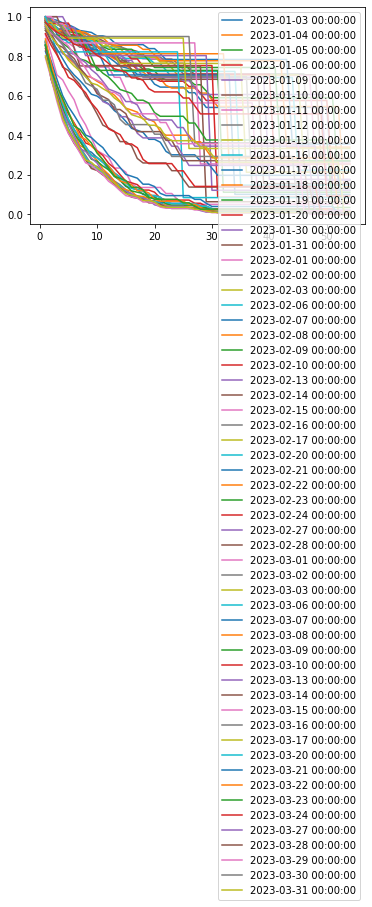

In [3119]:
cph.predict_survival_function(Xa_test,conditional_after=ya_test['T_alpha']).plot()  #生存的概率|

# Conduct Prediction for return decrease-Beta

In [3120]:
stock_datab = stock_datab.drop(['last_alpha_index','last_beta_index','is_alpha','T_alpha','cumulative_returns'], axis = 1)

In [3121]:
stock_datab = stock_datab.dropna()
stock_datab = stock_datab.reset_index()
stock_datab = stock_datab.drop('index', axis=1)

# 设置日期列为索引
stock_datab = stock_datab.set_index('Date')

In [3122]:
stock_datab.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1885 entries, 2015-07-23 to 2023-04-21
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   is_beta  1885 non-null   int64  
 1   T_beta   1885 non-null   int64  
 2   AcROC    1885 non-null   float64
 3   AvROC    1885 non-null   float64
 4   AcT      1885 non-null   float64
 5   AvT      1885 non-null   float64
 6   K%       1885 non-null   float64
 7   D%       1885 non-null   float64
 8   J%       1885 non-null   float64
 9   RSI      1885 non-null   float64
 10  PSY      1885 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 176.7 KB


In [3123]:
Xb = stock_datab
yb = stock_datab[['is_beta', 'T_beta']]#

In [3124]:
# 将历史数据作为训练集
# 将2023年2月份的数据作为测试集
Xb_train = Xb.loc[:'2022-12-30']
Xb_test  =Xb.loc['2023-01-02':'2023-03-31']

In [3125]:
Xb_train 

,is_beta,T_beta,AcROC,AvROC,AcT,AvT,K%,D%,J%,RSI,PSY
Date,,,,,,,,,,,
2015-07-23,0,6,3.567920,4.719421,1104776.83,7109.235667,79.370629,0.000000,238.111888,0.000000,0.366667
2015-07-24,1,7,3.456606,4.678685,1095269.18,7384.584333,72.014925,0.000000,216.044776,56.627368,0.354839
2015-07-27,1,1,3.598415,4.644927,1087006.67,7568.315000,54.093960,0.000000,162.281879,55.190036,0.343750
2015-07-28,0,1,3.875216,4.621602,1081492.42,7738.021667,42.058824,0.000000,126.176471,55.371622,0.363636
2015-07-29,0,2,3.755205,4.596120,1076397.39,7877.251000,46.875000,0.000000,140.625000,54.844093,0.382353
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,0,2,1.119277,2.352751,45744.91,440.423000,1.694915,58.931717,-112.778689,43.350273,0.472510
2022-12-27,0,3,1.117655,2.352079,45497.01,433.903333,8.474576,56.911173,-88.398617,41.185785,0.472797
2022-12-28,0,4,1.114434,2.351406,45284.80,425.663000,16.949153,54.930690,-59.013922,41.549089,0.473083


In [3126]:
# t alpha 本质上由 is alpha获得
Xb_train1=Xb_train.drop('is_beta',axis = 1)
Xb_train1=Xb_train1.drop('T_beta',axis = 1)

In [3127]:
yb_train = yb.loc[:'2022-12-30']
yb_test=yb.loc['2023-01-02':'2023-03-31']

In [3128]:
from lifelines import CoxPHFitter
Xb_test = Xb_test.drop('is_beta',axis = 1)
Xb_test =Xb_test.drop('T_beta',axis = 1)

In [3129]:
# 创建Cox回归模型
cph = CoxPHFitter(penalizer=0.2)

# 使用训练集对模型进行拟合
cph.fit(Xb_train, duration_col='T_beta', event_col='is_beta', show_progress=True)

Iteration 1: norm_delta = 0.47455, step_size = 0.9500, log_lik = -2117.56260, newton_decrement = 80.56175, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.03218, step_size = 0.9500, log_lik = -2039.11786, newton_decrement = 0.57457, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00277, step_size = 0.9500, log_lik = -2038.53337, newton_decrement = 0.00451, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00002, step_size = 1.0000, log_lik = -2038.52885, newton_decrement = 0.00000, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -2038.52885, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 1812 total observations, 1496 right-censored observations>

In [3130]:
# Print coefficients and hazard ratios
print(cph.summary)

                   coef  exp(coef)      se(coef)  coef lower 95%  \
covariate                                                          
AcROC     -1.755668e-01   0.838981  6.790807e-02   -3.086642e-01   
AvROC     -2.936492e-02   0.971062  1.157616e-01   -2.562534e-01   
AcT       -2.497711e-07   1.000000  2.296559e-07   -6.998884e-07   
AvT        1.897050e-04   1.000190  3.663467e-05    1.179023e-04   
K%        -4.870203e-03   0.995142  1.339104e-03   -7.494798e-03   
D%         5.473882e-03   1.005489  1.809549e-03    1.927230e-03   
J%        -2.666545e-03   0.997337  4.770092e-04   -3.601466e-03   
RSI        1.127225e-03   1.001128  4.962879e-03   -8.599838e-03   
PSY       -9.961037e+00   0.000047  1.734233e+00   -1.336007e+01   

           coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  cmp to  \
covariate                                                                     
AcROC       -4.246945e-02             0.734427             0.958420     0.0   
AvROC        1

Wald test

In [3131]:
# 计算每个自变量的 Wald 检验 p 值
p_values = cph.summary['p']

# 设置显著性水平为 0.05，得到阈值
alpha = 0.4
threshold = alpha / len(p_values)

# 筛选显著的自变量
significant_vars = ['T_beta','is_beta']
for var, p in p_values.iteritems():
    if p < threshold:
        significant_vars.append(var)
significant_vars

['T_beta', 'is_beta', 'AcROC', 'AvT', 'K%', 'D%', 'J%', 'PSY']

In [3132]:
# 重新拟合模型，保留显著的自变量
cph.fit(Xb_train[significant_vars], duration_col='T_beta', event_col='is_beta', show_progress=True)

Iteration 1: norm_delta = 0.47643, step_size = 0.9500, log_lik = -2117.56260, newton_decrement = 79.92785, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.03668, step_size = 0.9500, log_lik = -2039.97480, newton_decrement = 0.63487, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00325, step_size = 0.9500, log_lik = -2039.32846, newton_decrement = 0.00502, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00002, step_size = 1.0000, log_lik = -2039.32342, newton_decrement = 0.00000, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -2039.32342, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 1812 total observations, 1496 right-censored observations>

# C-index and Brier score to do Evaluation
### C-index is for accuracy of predicted survival time order, the more, the better
### Brier score measures the discrepancy between predicted probabilities and actual event occurrences

In [3133]:
from lifelines.utils import concordance_index


# 计算C-index
c_index = concordance_index(yb_test['T_beta'], -cph.predict_partial_hazard(Xb_test), yb_test['is_beta'])

# 输出C-index
print("C-index:", c_index)

C-index: 0.7710437710437711


In [3134]:
survival_func=cph.predict_survival_function(Xb_test,conditional_after=yb_test['T_beta'])
partial_hazards = cph.predict_partial_hazard(Xb_test.iloc[[0]]) 
probabilities = 1 - survival_func.apply(lambda x: np.exp(-x * partial_hazards.squeeze())) # Use squeeze() to match the dimensions
probabilities = probabilities.head(10)
probabilities

,2023-01-03,2023-01-04,2023-01-05,2023-01-06,2023-01-09,2023-01-10,2023-01-11,2023-01-12,2023-01-13,2023-01-16,...,2023-03-20,2023-03-21,2023-03-22,2023-03-23,2023-03-24,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31
1.0,0.836091,0.835863,0.827732,0.832065,0.836941,0.831705,0.829259,0.829902,0.833452,0.838149,...,0.849608,0.839045,0.840249,0.839949,0.838002,0.834223,0.833314,0.830448,0.833472,0.830331
2.0,0.822133,0.814434,0.807296,0.818407,0.821669,0.814135,0.807295,0.811995,0.820600,0.826127,...,0.849608,0.827906,0.830412,0.831368,0.828861,0.817803,0.815886,0.813058,0.816220,0.812830
3.0,0.800492,0.794573,0.791446,0.802007,0.806842,0.781761,0.787447,0.797811,0.807145,0.808815,...,0.849608,0.818006,0.821690,0.824671,0.819358,0.803076,0.800232,0.799292,0.800728,0.798974
4.0,0.780548,0.779254,0.772491,0.786155,0.779829,0.747990,0.771799,0.783017,0.787824,0.794406,...,0.849608,0.810278,0.814894,0.817758,0.805801,0.791513,0.787931,0.784940,0.788555,0.784528
5.0,0.765230,0.761017,0.754254,0.757436,0.751924,0.723317,0.755548,0.761873,0.771793,0.779695,...,0.849608,0.802300,0.807888,0.807969,0.794608,0.779530,0.775175,0.764434,0.775934,0.763884
6.0,0.747060,0.743541,0.721437,0.727977,0.731634,0.703916,0.732442,0.744417,0.755478,0.757185,...,0.849608,0.791007,0.797983,0.799941,0.783248,0.762508,0.757049,0.747506,0.758001,0.746844
7.0,0.729706,0.712231,0.688091,0.706683,0.715706,0.703916,0.713474,0.726734,0.730620,0.736723,...,0.849608,0.781750,0.789873,0.791833,0.765960,0.748524,0.742156,0.730356,0.743266,0.729579
8.0,0.698741,0.680554,0.664194,0.690038,0.715706,0.691804,0.694354,0.699944,0.708138,0.721169,...,0.849608,0.772407,0.781693,0.779555,0.750311,0.734398,0.727116,0.704364,0.728385,0.703416
9.0,0.667550,0.657910,0.645637,0.690038,0.705765,0.678212,0.665573,0.675872,0.691124,0.702882,...,0.849608,0.758274,0.769326,0.768486,0.738438,0.713042,0.704389,0.680996,0.705897,0.679896
10.0,0.645325,0.640351,0.645637,0.679679,0.694606,0.678212,0.639899,0.657754,0.671205,0.685566,...,0.849608,0.745551,0.758195,0.760107,0.724486,0.693860,0.683995,0.663395,0.685713,0.662184


In [3135]:
npro=len(probabilities)+1
npro

11

In [3136]:
df_probabilities = pd.DataFrame(columns=['2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06', '2023-01-09', '2023-01-10', '2023-01-11', '2023-01-12', '2023-01-13', '2023-01-16', '2023-01-17', '2023-01-18', '2023-01-19', '2023-01-20','2023-01-30', '2023-01-31', '2023-02-01', '2023-02-02', '2023-02-03', '2023-02-06', '2023-02-07', '2023-02-08', '2023-02-09', '2023-02-10', '2023-02-13', '2023-02-14', '2023-02-15', '2023-02-16', '2023-02-17', '2023-02-20', '2023-02-21', '2023-02-22', '2023-02-23', '2023-02-24', '2023-02-27', '2023-02-28', '2023-03-01', '2023-03-02', '2023-03-03', '2023-03-06', '2023-03-07', '2023-03-08', '2023-03-09', '2023-03-10', '2023-03-13', '2023-03-14', '2023-03-15', '2023-03-16', '2023-03-17', '2023-03-20', '2023-03-21', '2023-03-22', '2023-03-23', '2023-03-24', '2023-03-27', '2023-03-28', '2023-03-29', '2023-03-30', '2023-03-31'])

for i, row in probabilities.iterrows():
    df_probabilities = df_probabilities.append(pd.DataFrame([row.tolist()], columns=df_probabilities.columns))
df_probabilities.index = range(1, npro)
df_probabilities
#存下来
df_probabilities.to_csv('Beta_Probabilities'+company+'.csv',index=True)

<AxesSubplot:>

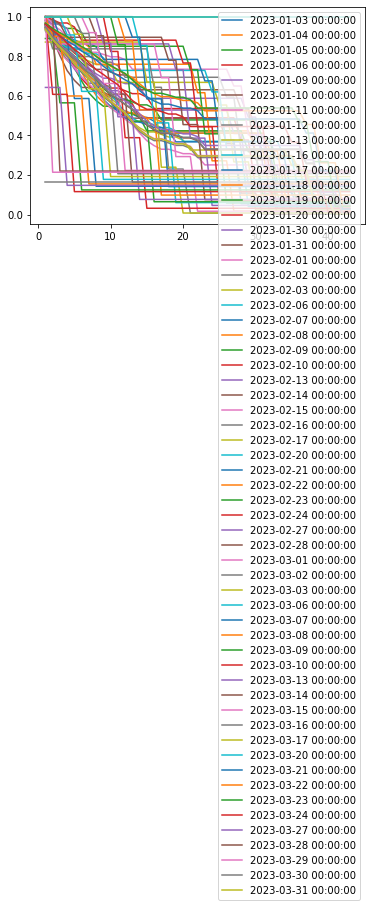

In [3137]:
cph.predict_survival_function(Xb_test,conditional_after=yb_test['T_beta']).plot()  #生存的概率